In [1]:
import sys
sys.path.append('../../')
from simCRN.multivariate_reg import read_eq_data_file
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from hyperopt import hp
from hyperopt import rand as hprand
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score

# Baseline model: Linear Model

In [3]:
np.seterr(under='warn') # run twice

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

Reading in the data

In [4]:
Ci_all_array, Am_array, Cmin, Cmax, Ai = read_eq_data_file('../2-2-2-semi-asym-AB-AC.txt')

In [5]:
print(Cmax)

3e-06


In [6]:
Am_array.shape

(2000, 2)

Prepare the data

In [7]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(Am_array, Ci_all_array, test_size=0.2, random_state=0)

Linear Model

In [8]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [9]:
clf = Ridge(alpha=1.0) # The linear regression model
tt_regressor = TransformedTargetRegressor(regressor=clf, transformer=StandardScaler())
pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

pipeline.fit(X_train, y_train)
y_hat_train = pipeline.predict(X_train)
y_hat_test = pipeline.predict(X_test)

In [10]:
train_mae = mae(y_train, y_hat_train, multioutput='raw_values')
test_mae = mae(y_test, y_hat_test, multioutput='raw_values')

print(f'The MAE on the training data for C₁ is {train_mae[0]:.3}') # 3 significant figures
print(f'The MAE on the training data for C₂ is {train_mae[1]:.3}')
print(f'The MAE on the test data for C₁ is {test_mae[0]:.3}')
print(f'The MAE on the test data for C₂ is {test_mae[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
means = np.mean(Ci_all_array, axis=0)
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, MAE/mean for C₁ is {test_mae[0]/means[0]:.3}')
print(f'For the test data, MAE/mean for C₂ is {test_mae[1]/means[1]:.3}')

The MAE on the training data for C₁ is 1.98e-07
The MAE on the training data for C₂ is 2.36e-07
The MAE on the test data for C₁ is 1.89e-07
The MAE on the test data for C₂ is 2.3e-07

The average value of C₁ is 1.52e-06
The average value of C₂ is 1.51e-06

For the test data, MAE/mean for C₁ is 0.124
For the test data, MAE/mean for C₂ is 0.152


In [11]:
train_mse = mse(y_train, y_hat_train, multioutput='raw_values')
test_mse = mse(y_test, y_hat_test, multioutput='raw_values')
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'The RMSE on the training data for C₁ is {train_rmse[0]:.3}') # 3 significant figures
print(f'The RMSE on the training data for C₂ is {train_rmse[1]:.3}')
print(f'The RMSE on the test data for C₁ is {test_rmse[0]:.3}')
print(f'The RMSE on the test data for C₂ is {test_rmse[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, RMSE/mean for C₁ is {test_rmse[0]/means[0]:.3}')
print(f'For the test data, RMSE/mean for C₂ is {test_rmse[1]/means[1]:.3}')

The RMSE on the training data for C₁ is 2.45e-07
The RMSE on the training data for C₂ is 2.81e-07
The RMSE on the test data for C₁ is 2.37e-07
The RMSE on the test data for C₂ is 2.74e-07

The average value of C₁ is 1.52e-06
The average value of C₂ is 1.51e-06

For the test data, RMSE/mean for C₁ is 0.156
For the test data, RMSE/mean for C₂ is 0.181


In [12]:
train_r2 = r2_score(y_train, y_hat_train, multioutput='raw_values')
test_r2 = r2_score(y_test, y_hat_test, multioutput='raw_values')

print(f'The R² on the training data for C₁ is {train_r2[0]:.3}') # 3 significant figures
print(f'The R² on the training data for C₂ is {train_r2[1]:.3}')
print(f'The R² on the test data for C₁ is {test_r2[0]:.3}')
print(f'The R² on the test data for C₂ is {test_r2[1]:.3}')

The R² on the training data for C₁ is 0.919
The R² on the training data for C₂ is 0.889
The R² on the test data for C₁ is 0.915
The R² on the test data for C₂ is 0.891


# Hyperparameter optimization

In [13]:
reg_type_list = ["Ridge", "Lasso"]
parameter_space =  {"reg_type": hp.choice("reg_type", reg_type_list), # L2 vs L1 regularization type
                    "reg": hp.uniform("reg", 0, 10), # try values between zero (no regularization) and 10 (high regularization)
                    }

In [14]:
# Evaluation function 
# args should be a dict, with keys for reg_type and reg
def model_eval(args):

    '''Take suggested arguments and perform model evaluation'''
    
    if args["reg_type"] == "Ridge":
        model = Ridge(alpha=args["reg"])
    elif args["reg_type"] == "Lasso":
        model = Lasso(alpha=args["reg"])
    else:
        raise Exception("Something has gone wrong!")
    tt_regressor = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
    pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

    scores = cross_val_score(pipeline, X_train, y=y_train, scoring='neg_mean_squared_error')

    cv_score = np.mean(scores)

    # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
    return -cv_score

In [15]:
print("Start trials") 

trials = Trials()
# use random search instead of TPE because of numerical underflow with TPE
best = fmin(model_eval, parameter_space, algo=hprand.suggest, max_evals=200, trials=trials) 

Start trials
100%|██████████| 200/200 [00:04<00:00, 48.20trial/s, best loss: 6.964524471740752e-14]


In [16]:
print("Best parameter set: {}".format(best))
print(f"model = {reg_type_list[best['reg_type']]}")
print(f"regularization = {best['reg']}")
print("Best loss from CV: {:.3}".format(trials.best_trial['result']['loss']))
print("Best RMSE loss from CV: {:.3}".format(np.sqrt(trials.best_trial['result']['loss'])))

Best parameter set: {'reg': 0.20558489528684332, 'reg_type': 0}
model = Ridge
regularization = 0.20558489528684332
Best loss from CV: 6.96e-14
Best RMSE loss from CV: 2.64e-07


# Train Optimized Model

In [17]:
from sklearn.model_selection import cross_validate

In [18]:
def optimized_model_eval(X_train, y_train, X_test, y_test, parameters, reg_type_list):

    '''Take suggested arguments and perform model evaluation'''
    regularization = parameters["reg"]
    if reg_type_list[parameters["reg_type"]] == "Ridge":
        model = Ridge(alpha=regularization)
    elif reg_type_list[parameters["reg_type"]] == "Lasso":
        model = Lasso(alpha=regularization)
    else:
        raise Exception("Something has gone wrong!")
    
    tt_regressor = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
    pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

    # Train 5 models on random 80/20 test splits of the input data
    scores = cross_validate(pipeline, X_train, y=y_train, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], \
                             return_estimator=True)
    
    # Get average validation MSE
    mean_val_mse = -np.mean(scores['test_neg_mean_squared_error'])
    mean_val_mae = -np.mean(scores['test_neg_mean_absolute_error'])
    
    # Calculate test MSE
    test_mse_arr = np.zeros((5,2))
    test_mae_arr = np.zeros((5,2))
    for i in range(5):
        y_test_pred = scores['estimator'][i].predict(X_test)
        test_mse_arr[i,:] = mse(y_test, y_test_pred, multioutput='raw_values')
        test_mae_arr[i,:] = mae(y_test, y_test_pred, multioutput='raw_values')
    mean_test_mse = np.mean(test_mse_arr)
    mean_test_mae = np.mean(test_mae_arr)
    

    # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
    return scores, mean_val_mse, mean_val_mae, test_mse_arr, test_mae_arr, mean_test_mse, mean_test_mae

In [19]:
optimized_scores, optimized_val_mse, optimized_val_mae, optimized_test_mse_arr, optimized_test_mae_arr, \
optimized_mean_test_mse, optimized_mean_test_mae \
= optimized_model_eval(X_train, y_train, X_test, y_test, best, reg_type_list)

In [20]:
print(f"Optimized average validation MSE: {optimized_val_mse:.3}")
print(f"Optimized average validation RMSE: {np.sqrt(optimized_val_mse):.3}")
print(f"Optimized average validation MAE: {optimized_val_mae:.3}")

Optimized average validation MSE: 6.96e-14
Optimized average validation RMSE: 2.64e-07
Optimized average validation MAE: 2.17e-07


In [21]:
print(f"Optimized average test MSE: {optimized_mean_test_mse:.3}")
print(f"Optimized average test RMSE: {np.sqrt(optimized_mean_test_mse):.3}")
print(f"Optimized average test MAE: {optimized_mean_test_mae:.3}")

Optimized average test MSE: 6.56e-14
Optimized average test RMSE: 2.56e-07
Optimized average test MAE: 2.09e-07


In [22]:
print(f"Optimized average validation MSE: {optimized_val_mse}")
print(f"Optimized average validation RMSE: {np.sqrt(optimized_val_mse)}")
print(f"Optimized average validation MAE: {optimized_val_mae}")
print(f"Optimized average test MSE: {optimized_mean_test_mse}")
print(f"Optimized average test RMSE: {np.sqrt(optimized_mean_test_mse)}")
print(f"Optimized average test MAE: {optimized_mean_test_mae}")

Optimized average validation MSE: 6.964524471740752e-14
Optimized average validation RMSE: 2.6390385506355816e-07
Optimized average validation MAE: 2.169507906543017e-07
Optimized average test MSE: 6.564117022918748e-14
Optimized average test RMSE: 2.5620532826072816e-07
Optimized average test MAE: 2.0911316473989605e-07


# Reducing Dataset Size

In [23]:
def prep_data(X, y, total_size, test_size, random_state):
    # Calculate the size of the reduced data set
    total_frac = total_size/y.shape[0]
    # Reducing the dataset size
    X_train_all, X_test_all, y_train_all, y_test_all = \
    train_test_split(X, y, test_size=1-total_frac, random_state=random_state)
    
    # Splitting into train and test
    X_train, X_test, y_train, y_test = \
    train_test_split(X_train_all, y_train_all, test_size=test_size, random_state=random_state)
    
    return(X_train, X_test, X_test_all, y_train, y_test, y_test_all)

In [26]:
# Reduced data set sizes
data_set_sizes = 2000 * 0.5 ** np.arange(1,6)
print(data_set_sizes)
# Lists to store data and results in
trials_list = []
best_params_list = []
X_train_list = []
X_test_list = []
X_test_all_list = []
y_train_list = []
y_test_list = []
y_test_all_list = []

[1000.   500.   250.   125.    62.5]


In [27]:
# Iterate through smaller data set sizes
for data_set_size in data_set_sizes:
    print(f"Data set size: {data_set_size}")
    X_train_sub, X_test_sub, X_test_all, y_train_sub, y_test_sub, y_test_all = \
    prep_data(X_train, y_train, data_set_size, 0.2, 0)
    # Add data sets to lists
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    X_test_all_list.append(X_test_all)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    y_test_all_list.append(y_test_all)
    def model_eval_data_set(args):

        '''Take suggested arguments and perform model evaluation'''

        if args["reg_type"] == "Ridge":
            model = Ridge(alpha=args["reg"])
        elif args["reg_type"] == "Lasso":
            model = Lasso(alpha=args["reg"])
        else:
            raise Exception("Something has gone wrong!")
        tt_regressor = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
        pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

        scores = cross_val_score(pipeline, X_train, y=y_train, scoring='neg_mean_squared_error')

        cv_score = np.mean(scores)

        # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
        return -cv_score
    # Hyperparameter optimize
    trials = Trials()
    best = fmin(model_eval_data_set, parameter_space, algo=hprand.suggest, max_evals=200, trials=trials)
    trials_list.append(trials)
    best_params_list.append(best)
    print("Best parameter set: {}".format(best))
    print(f"model = {reg_type_list[best['reg_type']]}")
    print(f"regularization = {best['reg']}")

Data set size: 1000.0
100%|██████████| 200/200 [00:03<00:00, 50.68trial/s, best loss: 6.964525624570723e-14]
Best parameter set: {'reg': 0.14245469865609595, 'reg_type': 0}
model = Ridge
regularization = 0.14245469865609595
Data set size: 500.0
100%|██████████| 200/200 [00:03<00:00, 53.12trial/s, best loss: 6.964524608017293e-14]
Best parameter set: {'reg': 0.22017647188734446, 'reg_type': 0}
model = Ridge
regularization = 0.22017647188734446
Data set size: 250.0
100%|██████████| 200/200 [00:03<00:00, 50.36trial/s, best loss: 6.964579959451518e-14]
Best parameter set: {'reg': 0.5955966224536968, 'reg_type': 0}
model = Ridge
regularization = 0.5955966224536968
Data set size: 125.0
100%|██████████| 200/200 [00:04<00:00, 48.49trial/s, best loss: 6.964524500074153e-14]
Best parameter set: {'reg': 0.18904428103956983, 'reg_type': 0}
model = Ridge
regularization = 0.18904428103956983
Data set size: 62.5
100%|██████████| 200/200 [00:04<00:00, 46.66trial/s, best loss: 6.964524889032602e-14]
Be

# Train Optimized Models (Reduced Dataset)

In [28]:
mean_val_mse_list = []
mean_val_mae_list = []
mean_test_mse_list = []
mean_test_mae_list = []
for i in range(len(data_set_sizes)):
    scores, mean_val_mse, mean_val_mae, test_mse_arr, test_mae_arr, mean_test_mse, mean_test_mae = \
    optimized_model_eval(X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i], \
                         best_params_list[i], reg_type_list)
    mean_val_mse_list.append(mean_val_mse)
    mean_val_mae_list.append(mean_val_mae)
    mean_test_mse_list.append(mean_test_mse)
    mean_test_mae_list.append(mean_test_mae)

In [29]:
print("Mean validation MSE list")
print(mean_val_mse_list)
print("Mean validation MAE list")
print(mean_val_mae_list)

Mean validation MSE list
[7.132254146921614e-14, 7.255618541083622e-14, 6.796156134982812e-14, 7.612216156126768e-14, 7.858356404610193e-14]
Mean validation MAE list
[2.1893241670701127e-07, 2.2398102570074637e-07, 2.1316876590079973e-07, 2.276827447202582e-07, 2.387255999324833e-07]


In [30]:
for i in range(len(data_set_sizes)):
    print(f"Data set size: {data_set_sizes[i]}")
    print(f"Optimized average validation MSE: {mean_val_mse_list[i]:.3}")
    print(f"Optimized average validation RMSE: {np.sqrt(mean_val_mse_list[i]):.3}")
    print(f"Optimized average validation MAE: {mean_val_mae_list[i]:.3}")

Data set size: 1000.0
Optimized average validation MSE: 7.13e-14
Optimized average validation RMSE: 2.67e-07
Optimized average validation MAE: 2.19e-07
Data set size: 500.0
Optimized average validation MSE: 7.26e-14
Optimized average validation RMSE: 2.69e-07
Optimized average validation MAE: 2.24e-07
Data set size: 250.0
Optimized average validation MSE: 6.8e-14
Optimized average validation RMSE: 2.61e-07
Optimized average validation MAE: 2.13e-07
Data set size: 125.0
Optimized average validation MSE: 7.61e-14
Optimized average validation RMSE: 2.76e-07
Optimized average validation MAE: 2.28e-07
Data set size: 62.5
Optimized average validation MSE: 7.86e-14
Optimized average validation RMSE: 2.8e-07
Optimized average validation MAE: 2.39e-07


In [31]:
print("Mean test MSE list")
print(mean_test_mse_list)
print("Mean test MAE list")
print(mean_test_mae_list)

Mean test MSE list
[6.839476049806177e-14, 7.136777931743839e-14, 6.89071234173469e-14, 7.543327767955187e-14, 6.272793386900507e-14]
Mean test MAE list
[2.1664027061440714e-07, 2.1907334750841946e-07, 2.2125536552469512e-07, 2.296508332814697e-07, 1.97782497175954e-07]


In [32]:
for i in range(len(data_set_sizes)):
    print(f"Data set size: {data_set_sizes[i]}")
    print(f"Optimized average test MSE: {mean_test_mse_list[i]:.3}")
    print(f"Optimized average test RMSE: {np.sqrt(mean_test_mse_list[i]):.3}")
    print(f"Optimized average test MAE: {mean_test_mae_list[i]:.3}")

Data set size: 1000.0
Optimized average test MSE: 6.84e-14
Optimized average test RMSE: 2.62e-07
Optimized average test MAE: 2.17e-07
Data set size: 500.0
Optimized average test MSE: 7.14e-14
Optimized average test RMSE: 2.67e-07
Optimized average test MAE: 2.19e-07
Data set size: 250.0
Optimized average test MSE: 6.89e-14
Optimized average test RMSE: 2.63e-07
Optimized average test MAE: 2.21e-07
Data set size: 125.0
Optimized average test MSE: 7.54e-14
Optimized average test RMSE: 2.75e-07
Optimized average test MAE: 2.3e-07
Data set size: 62.5
Optimized average test MSE: 6.27e-14
Optimized average test RMSE: 2.5e-07
Optimized average test MAE: 1.98e-07


# Plots 

In [38]:
plt.rcParams.update({'font.size': 16})
plot_data_set_sizes = 2000 * 0.5 ** np.arange(0,6)
# mean_val_mse_list.insert(0, optimized_val_mse)
# mean_val_mae_list.insert(0, optimized_val_mae)
# mean_test_mse_list.insert(0, optimized_mean_test_mse)
# mean_test_mae_list.insert(0, optimized_mean_test_mae)
print("Validation MSE")
print(mean_val_mse_list)
print("Validation MAE")
print(mean_val_mae_list)
print("Test MSE")
print(mean_test_mse_list)
print("Test MAE")
print(mean_test_mae_list)

Validation MSE
[6.964524471740752e-14, 7.132254146921614e-14, 7.255618541083622e-14, 6.796156134982812e-14, 7.612216156126768e-14, 7.858356404610193e-14]
Validation MAE
[2.169507906543017e-07, 2.1893241670701127e-07, 2.2398102570074637e-07, 2.1316876590079973e-07, 2.276827447202582e-07, 2.387255999324833e-07]
Test MSE
[6.564117022918748e-14, 6.839476049806177e-14, 7.136777931743839e-14, 6.89071234173469e-14, 7.543327767955187e-14, 6.272793386900507e-14]
Test MAE
[2.0911316473989605e-07, 2.1664027061440714e-07, 2.1907334750841946e-07, 2.2125536552469512e-07, 2.296508332814697e-07, 1.97782497175954e-07]


In [39]:
case = "2-2-2 Case 2"
save_name = "lm_2-2-2_semi-asym"

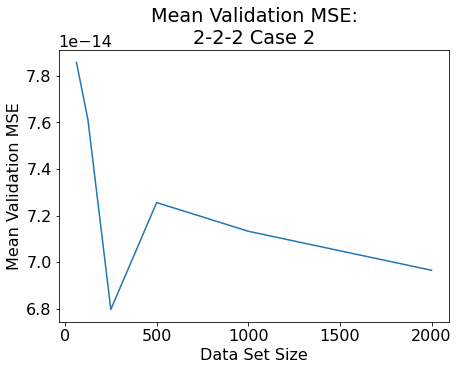

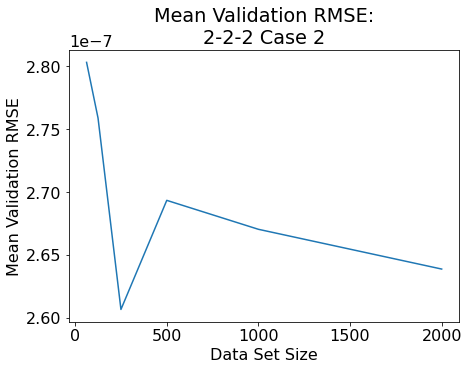

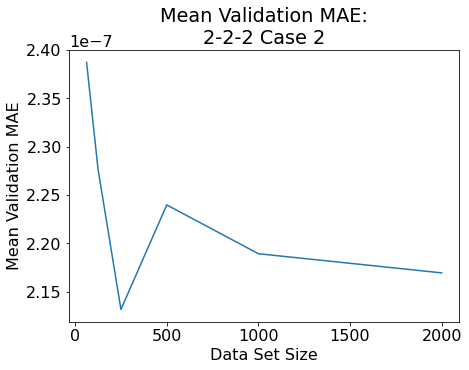

In [40]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_val_mse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation MSE")
plt.title(f"Mean Validation MSE:\n{case}")
plt.savefig(f"{save_name}_val_mse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, np.sqrt(mean_val_mse_list))
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation RMSE")
plt.title(f"Mean Validation RMSE:\n{case}")
plt.savefig(f"{save_name}_val_rmse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_val_mae_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation MAE")
plt.title(f"Mean Validation MAE:\n{case}")
plt.savefig(f"{save_name}_val_mae_vs_data.png")

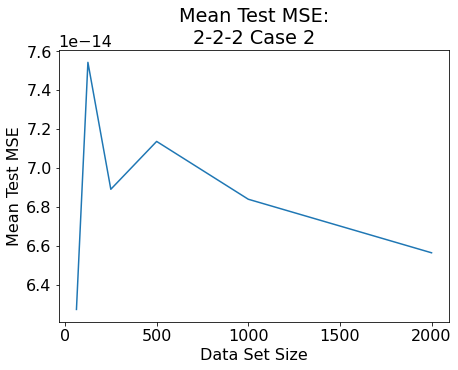

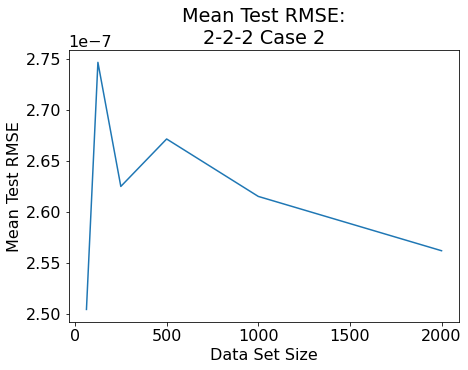

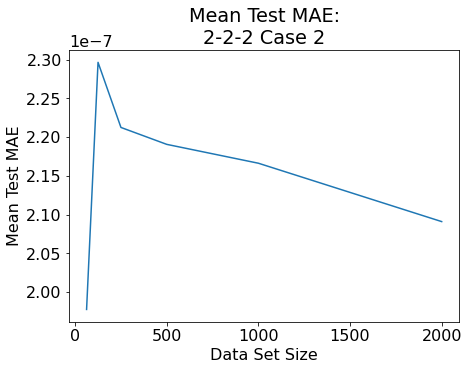

In [41]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_test_mse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test MSE")
plt.title(f"Mean Test MSE:\n{case}")
plt.savefig(f"{save_name}_test_mse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, np.sqrt(mean_test_mse_list))
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test RMSE")
plt.title(f"Mean Test RMSE:\n{case}")
plt.savefig(f"{save_name}_test_rmse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(plot_data_set_sizes, mean_test_mae_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test MAE")
plt.title(f"Mean Test MAE:\n{case}")
plt.savefig(f"{save_name}_test_mae_vs_data.png")